# Point pattern analysis

When you need to deal with point data, you will likely be interested in
the spatial patterns they form. For that, you can use point pattern
analysis techniques. This session will walk you through some basic ways
of approaching the analysis based primarily on geometries and their
locations rather than variables associated with them.

In [1]:
import contextily
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pointpats
import seaborn as sns
from matplotlib import patches
from sklearn import cluster

c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\pointpats\pointpattern.py:277: SyntaxWarning: invalid escape sequence '\m'
  """
c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\pointpats\process.py:159: SyntaxWarning: invalid escape sequence '\l'
  """
c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\pointpats\process.py:296: SyntaxWarning: invalid escape sequence '\l'
  """


## Data

In this session, you will be using data on pedestrian accidents in Brno
that happened since 2010. Every accident is marked with point geometry
and assigned a range of relevant variables you are free to explore by
yourself. The dataset is
[released](https://data.brno.cz/datasets/mestobrno::nehody-s-účastí-chodců-pedestrian-accidents/about)
by Brno municipality under CC-BY 4.0 license. It has been preprocessed
for the purpose of this course. If you want to see how the table was
created, a notebook is available
[here](../data/brno_pedestrian_accidents/preprocessing.ipynb).

As always, you can read data from a file posted online, so you do not
need to download any dataset:

In [46]:
accidents = gpd.read_file(
    "https://martinfleischmann.net/sds/point_patterns/data/brno_pedestrian_accidents.gpkg"
)
accidents.explore("rok", tiles="CartoDB Positron", cmap="magma_r")
len(accidents.index)

2602

> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/point_patterns/data/brno_pedestrian_accidents.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> accidents = gpd.read_file(
>     "brno_pedestrian_accidents.gpkg",
> )
> ```

## Visualisation

The first step you will likely do is some form of visualisation. Either
as an interactive map like the one above or using one of the more
advanced methods. Most of the methods you will be using today do not
necessarily depend on geometries but on their coordinates. Let’s start
by extracting coordinates from geometries and assigning them as columns.

In [3]:
accidents[["x", "y"]] = accidents.get_coordinates()
accidents.head(2)

,den,rok,mesic,zavineni,viditelnost,cas,mesic_t,doba,den_v_tydnu,alkohol,...,kategorie_chodce,stav_chodce,chovani_chodce,situace_nehody,prvni_pomoc,nasledky_chodce,nazev,geometry,x,y
0,4,2010,4,chodcem,"ve dne, viditelnost nezhoršená vlivem povětrno...",1340,duben,den,čtvrtek,Ne,...,muž,"nepozornost, roztržitost",špatný odhad vzdálenosti a rychlosti vozidla,přecházení mimo přechod (2O a více metrů od př...,nebylo třeba poskytnout,bez zranění,Brno-Starý Lískovec,POINT (-601201.157 -1164285.355),-601201.157,-1164285.355
1,6,2010,6,řidičem motorového vozidla,"ve dne, viditelnost nezhoršená vlivem povětrno...",1560,červen,den,sobota,Ne,...,jiná skupina,nezjištěno,žádné z uvedených,jiná situace,vozidlem RZP,lehké zranění,Brno-jih,POINT (-597104.108 -1165612.168),-597104.108,-1165612.168


### Scatter plots and distributions

Any geographical plot of points is essentially a scatter plot based on
their x and y coordinates. You can use this to your advantage and
directly apply visualisation methods made for scatterplots. `seaborn` is
able to give you a scatter plot with histograms per each axis.

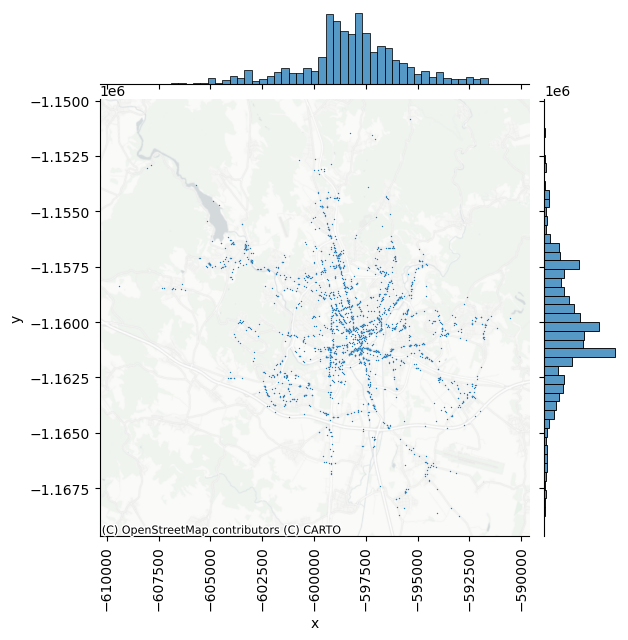

In [ ]:
axs = sns.jointplot(x="x", y="y", data=accidents, s=1)
contextily.add_basemap(
    ax=axs.ax_joint, crs=accidents.crs, source="CartoDB Positron No Labels"
)
plt.xticks(rotation=90)

This plot is useful as it indicates that the point pattern has a
tendency to be organised around a single centre (both histograms
resemble normal distribution). From the map, you can see that the
majority of incidents happened along main roads (as one would expect),
but showing raw points on a map is not the best visualisation method.
You can conclude that the pattern is not random (more on that later).

Showing all the points on a map is not that terrible in this case as
there’s not that many of them. However, even in this case, you face the
issue of clusters of points being hidden behind a single *dot* and
similar legibility drawbacks. You can overcome it it many ways, so let’s
showcase two of them - binning and density estimation.

### Hexagonal binning

Binning is, in principle, a spatial join between the point pattern and
an arbitrary grid overlaid on top. What you are interested is the number
of points that fall into each grid cell. An example can be hexagonal
binning, when the arbitrary grid is composed of hexagons. You could do
it using geospatial operations in `geopandas` but since you have just
points and all you now want is a plot, you can use `hexbin()` method
from `matplotlib`.

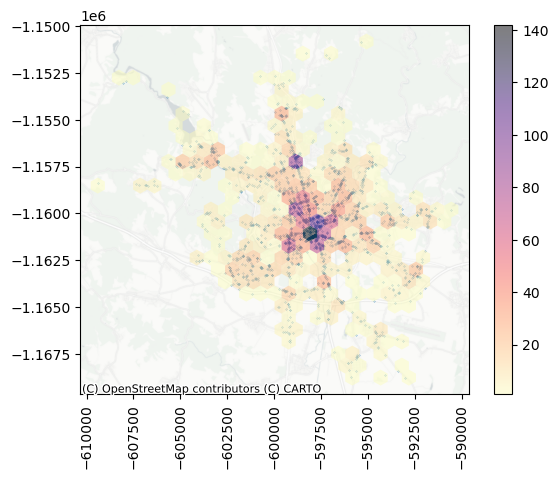

In [5]:
f, ax = plt.subplots()
accidents.plot(ax=ax, markersize=0.05)
hb = ax.hexbin(
    accidents["x"],
    accidents["y"],
    gridsize=25,
    linewidths=0,
    alpha=0.5,
    cmap="magma_r",
    mincnt=1,
)
# Add basemap
contextily.add_basemap(
    ax=ax,
    crs=accidents.crs,
    source="CartoDB Positron No Labels",
)
# Add colorbar
plt.colorbar(hb)
plt.xticks(rotation=90);

Hexbin gives you a better sense of the density of accidents across the
city. There seems to be a large hotspot in the central areas and a few
other places that seem to be more dangerous.

### Kernel density estimation

Density can be estimated by binning, but that will always result in
abrupt changes when two cells meet, like with a histogram. The other
option is to use 2-dimensional kernel density estimation to generate
contours of different (interpolated) levels of density. If you are
interested in a plot and not geometry of contour lines, `pointpats`
offers a handy function called `plot_density()`.

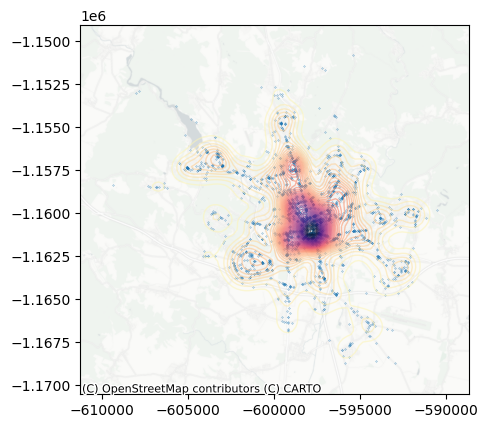

In [45]:
f, ax = plt.subplots()
accidents.plot(ax=ax, markersize=0.05)
pointpats.plot_density(
    accidents,
    bandwidth=500,
    levels=50,
    alpha=0.55,
    cmap="magma_r",
    linewidths=1,
    ax=ax,
)
contextily.add_basemap(
    ax=ax,
    crs=accidents.crs,
    source="CartoDB Positron No Labels",
)

The intuition about the dominance of the city centre in the dataset is
shown here very clearly. What have all of these visualisations in common
is that they can be used to build intuition and a first insight into the
pattern but as data scientists, you will probably need some numbers
characterising your data.

## Centrography

Centrography aims to provide a summary of the pattern. What is the
general location of the pattern, how dispersed is it, or where are its
limits. You can imagine it as what `pandas.DataFrame.describe()` returns
but for the point pattern. @rey2023geographic cover assessments of
*tendency*, *dispersion* and *extent*.

The tendency can be reflected by the centre of mass represented usually
as the mean or median of point coordinates. PySAL has a module dedicated
to point patterns called `pointpats`, that allows you to measure these
easily, just based on an array of X and Y coordinates.

In [7]:
mean_center = pointpats.centrography.mean_center(accidents[["x", "y"]])
med_center = pointpats.centrography.euclidean_median(accidents[["x", "y"]])

On some occasions, you may want to take into account some external
variables apart from the geographical location of each point. Simply
because not every accident is as serious as the other. You can use
`weighted_mean_center` to measure mean weighted by any arbitrary value.
In the case of accidents, you may be interested in mean weighted by the
number of injured people.

In [8]:
weighted_mean = pointpats.centrography.weighted_mean_center(
    accidents[["x", "y"]], accidents["lehce_zran_os"]
)

What you get back for each of these are coordinates of a single point
that is, to some degree, representative of the pattern.

In [9]:
weighted_mean

array([ -598188.52908271, -1160167.63045074])

Dispersion can be reflected by the standard deviation or, better, by the
ellipse based on the standard deviations in both directions since you
are dealing with two-dimensional data. The `pointpats.centrography` can
also do that, giving you back the semi-major and semi-minor axes and
their rotation.

In [10]:
major, minor, rotation = pointpats.centrography.ellipse(accidents[["x", "y"]])

You can then use the information in any way you like, but it is likely
that you will want to plot the results of centrography on a map. The
plot is a bit more complicated than those before, but it is just because
there are more layers. However, do not feel the need to reproduce it.

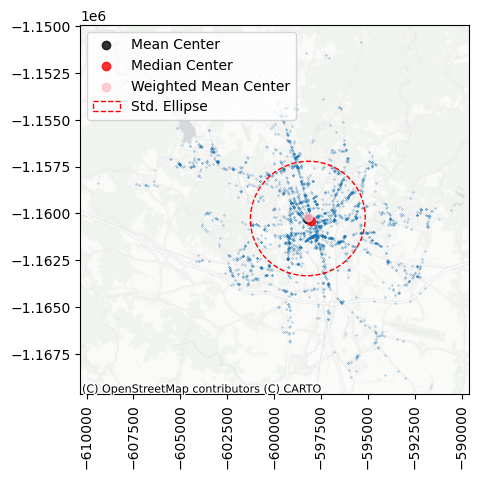

In [11]:
f, ax = plt.subplots()
accidents.plot(ax=ax, markersize=0.05)

ax.scatter(*mean_center, color="k", marker="o", label="Mean Center", alpha=0.8)
ax.scatter(*med_center, color="r", marker="o", label="Median Center", alpha=0.8)
ax.scatter(
    *weighted_mean,
    color="pink",
    marker="o",
    label="Weighted Mean Center",
    alpha=0.8
)

ellipse = patches.Ellipse(
    xy=mean_center,
    width=major * 2,
    height=minor * 2,
    angle=np.rad2deg(rotation),
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)
ax.legend(loc="upper left")

contextily.add_basemap(
    ax=ax,
    crs=accidents.crs,
    source="CartoDB Positron No Labels",
)
plt.xticks(rotation=90);

You can see that in this specific case, all three ways of computing
centre of the mass are within a short distance from each other,
suggesting the dataset is pretty balanced. A similar conclusion can be
made based on the shape of the ellipse, which nearly resembles a circle.

A useful application of centrography is when you need to compare
mutliple point patterns. Have a look at the difference between accidents
that happened during the day and at night (column `"doba"`, where “den”
means day and “noc” means night).

In [12]:
day = accidents[accidents["doba"] == "den"]
night = accidents[accidents["doba"] == "noc"]

As always, start with visual exploration.

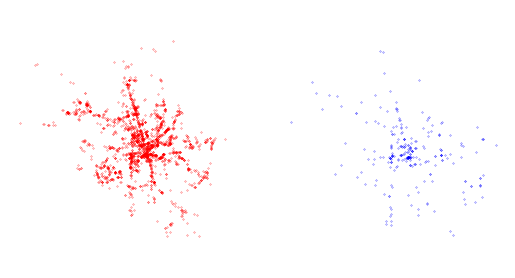

In [13]:
f, axs = plt.subplots(1, 2, sharey=True)
day.plot(color="red", markersize=.05, ax=axs[0])
night.plot(color='blue', markersize=.05, ax=axs[1])
for ax in axs:
    ax.set_axis_off()

Focus on the ellipse. What does it say about the patterns? How does it
change and why?

In [14]:
mean_center_day = pointpats.centrography.mean_center(day[["x", "y"]])
mean_center_night = pointpats.centrography.mean_center(night[["x", "y"]])

major_day, minor_day, rotation_day = pointpats.centrography.ellipse(
    day[["x", "y"]]
)
major_night, minor_night, rotation_night = pointpats.centrography.ellipse(
    night[["x", "y"]]
)

Compare the two ellipses visually on a map.

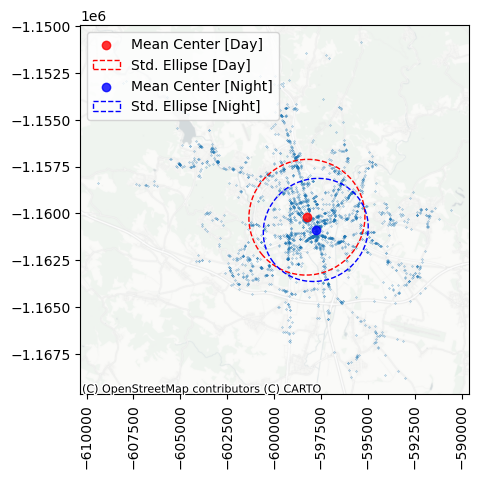

In [15]:
f, ax = plt.subplots()
accidents.plot(ax=ax, markersize=0.05)

ax.scatter(*mean_center_day, color="red", marker="o", label="Mean Center [Day]", alpha=0.8)
ellipse = patches.Ellipse(
    xy=mean_center_day,
    width=major_day * 2,
    height=minor_day * 2,
    angle=np.rad2deg(rotation_day),
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse [Day]",
)
ax.add_patch(ellipse)

ax.scatter(*mean_center_night, color="blue", marker="o", label="Mean Center [Night]", alpha=0.8)
ellipse = patches.Ellipse(
    xy=mean_center_night,
    width=major_night * 2,
    height=minor_night * 2,
    angle=np.rad2deg(rotation_night),
    facecolor="none",
    edgecolor="blue",
    linestyle="--",
    label="Std. Ellipse [Night]",
)
ax.add_patch(ellipse)

ax.legend(loc="upper left")

contextily.add_basemap(
    ax=ax,
    crs=accidents.crs,
    source="CartoDB Positron No Labels",
)
plt.xticks(rotation=90);

As you can see, the night ellipse is slightly smaller and centred closer
to the centre of Brno than the day ellipse. You can probably guess why.

> **Extent**
>
> The last part of centrography worth mentioning here are ways of
> characterisation of pattern’s extent. This is not covered in this
> material but feel free to jump directly to the [relevant
> section](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html#extent)
> of the *Point Patterns* chapter by @rey2023geographic.

All centrography measures are crude simplifications of the pattern like
summary statistics is a for non-spatial data. Let’s move towards some
more profound methods of analysis.

## Randomness and clustering

Point patterns can be random but more often then not, they are not
random. You main question when looking at the observations can be
targetting specifically this distinction. *Is, whatever I am looking at,
following some underlying logic or is it random?* The first method that
helps answering such questions is quadrat statistic.

### Quadrat statistic

Imagine a grid overlaid over the map, similar to those you can use for
visualisation. Each of them contains a certain number of points of the
pattern. Quadrat statistics “examine the evenness of the distribution
over cells using a $\chi^2$ statistical test common in the analysis of
contingency tables.” \[@rey2023geographic\]. It compares the actual
distribution of points in cells to that, that would be present if the
points were allocated randomly.

`pointpats` allows you to compute the statistics using the `QStatistic`
class, which takes the array of coordinates and some optional parameters
specifying the details.

In [16]:
qstat = pointpats.QStatistic(accidents[["x", "y"]].values, nx=6, ny=6)

The class then offers a range of statistical values in a similar way you
know from those in `esda`, you used last time. For example, the observed
$\chi^2$ statistics can be accessed using `.chi2`.

In [17]:
qstat.chi2

11450.396617986164

And it’s $p$-value, indicating significance using `chi2_pvalue`.

In [18]:
qstat.chi2_pvalue

0.0

In our case, it is clear that the points are not evenly distributed
across the cells, hence the point pattern is unlikely to be random. A
helpful visual illustration of how the quadrat overlay works is when you
plot the grid on top of the underlying point pattern.

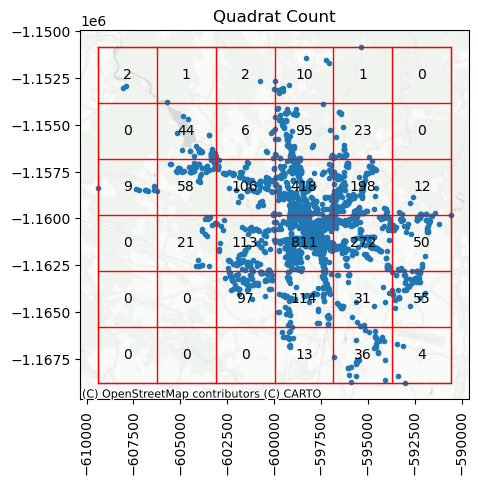

In [19]:
ax = qstat.plot()
contextily.add_basemap(
    ax=ax,
    crs=accidents.crs,
    source="CartoDB Positron No Labels",
)
plt.xticks(rotation=90);

You can see that there are cells with more than 800 observations, while
some others have tens or even zeros.

### Ripley’s functions

A better option for the assessment of the randomness of a point pattern
is a family of statistical methods called Ripley’s alphabet. These
functions tend to work with the concept of nearest neighbours and aim to
capture the co-location of points in the pattern.

Before working with any of those, let’s quickly look at the Quadrat
statistic plot above. Some of the cells contain 0 points simply because
the extent of the point pattern is smaller than the bounding box of the
area. Since Ripley’s functions are based on the generation of random
point patterns within the extent of the analysed one, a situation like
this might unnecessarily skew the results. To minise this effect, you
want to perform the test only within the area of the existing point
pattern.

While you can define such an extent in many way, a simple and often very
suitable method is to define a concave hull of the point pattern to
limit the possible space where modelled point locations may occur. You
can do that directly with `geopandas`.

In [24]:
concave_hull = accidents.dissolve().concave_hull(ratio=.5)

The resulting object is a `shapely.Polygon`. If you wrap it in a
`geopandas.GeoSeries`, you can easily plot it:

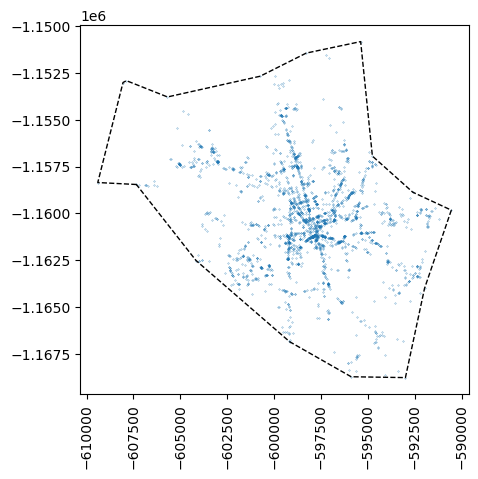

In [25]:
ax = accidents.plot(markersize=0.05)
concave_hull.plot(
    ax=ax, facecolor="none", edgecolor="k", linestyle="--"
)
plt.xticks(rotation=90);

This allows us to limit the test to the area where something already
happens.

#### $G$ function

Ripley’s $G$ is an iterative algorithm. It measures how many points have
the nearest point within a threshold distance while repeatedly
increasing such a threshold. A series of thresholds and counts then
results in a specific curve that is compared to the curve coming from
the purely random point pattern.

`pointpats` allows you to compute Ripley’s $G$ using the `g_test`
function.

In [29]:
g_test = pointpats.distance_statistics.g_test(
    accidents[["x", "y"]].values,
    support=200,
    keep_simulations=True,
    hull=concave_hull.item(),
    n_simulations=500,
)

The intuition behind the statistic can be built based on the plot of the
$G$ values per distance threshold, comparing the observed results with
those based on simulated random point patterns.

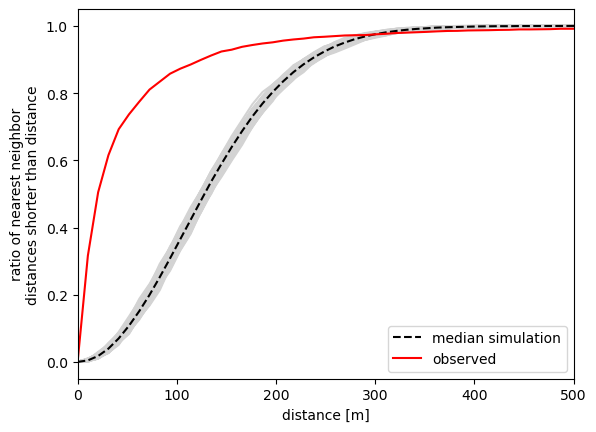

In [30]:
f, ax = plt.subplots()
ax.plot(g_test.support, g_test.simulations.T, color="lightgrey")
ax.plot(
    g_test.support,
    np.median(g_test.simulations, axis=0),
    color="k",
    label="median simulation",
    linestyle="--",
)
ax.plot(g_test.support, g_test.statistic, label="observed", color="red")
ax.set_xlabel("distance [m]")
ax.set_ylabel(
    "ratio of nearest neighbor\n"
    "distances shorter than distance"
)
ax.legend()
ax.set_xlim(0, 500);

The x-axis shows the distance threshold, while the y-axis shows the
ratio of points whose nearest neighbour is closer than the distance.
This curve resembles a sigmoid function in its shape when the point
pattern is random, as illustrated by the simulations. For non-random
patterns, the ratio tends to grow much quicker as points are more
clustered in space, making the nearest neighbours closer than the random
ones would be. Since we see this distinction clearly, we can assume that
the point pattern of pedestrian accidents is spatially clustered. The
available $p$-value can also back the significance of this observation.

In [31]:
np.mean(g_test.pvalue)

0.0034431137724550893

#### $F$ function

Another part of the Ripley’s alphabet is the $F$ function. It is similar
as $G$ in its iterative nature based on a distance threshold but instead
of focusing on distances between points within a pattern, if looks at
the distance to points from locations in empty space. It captures how
many points can be reached within a distance from a random point pattern
generated within the same extent (that is why passing the `hull` is
essential).

`pointpats` allows you to compute Ripley’s $F$ using the `f_test`
function.

In [33]:
f_test = pointpats.distance_statistics.f_test(
    accidents[["x", "y"]].values,
    support=200,
    keep_simulations=True,
    hull=concave_hull.item(),
    n_simulations=500,
)

Again, it is easier to understand the function from the plot. Patterns
clustered in space tend to have larger empty spaces between their
clusters, leading to a slower increase of $F$ than what would happen for
a random point pattern. That is precisely what you can see in the figure
below.

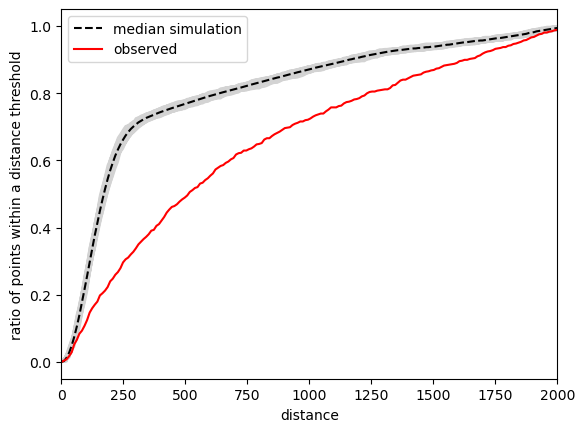

In [34]:
f, ax = plt.subplots()
ax.plot(f_test.support, f_test.simulations.T, color="lightgrey")
ax.plot(
    f_test.support,
    np.median(f_test.simulations, axis=0),
    color="k",
    label="median simulation",
    linestyle="--",
)
ax.plot(f_test.support, f_test.statistic, label="observed", color="red")
ax.set_xlabel("distance")
ax.set_ylabel("ratio of points within a distance threshold")
ax.legend()
ax.set_xlim(0, 2000);

The observed curve of the $F$ function is clearly below the simulated,
meaning that it increases more slowly than it should if it were a random
pattern. You can conclude the same as above: the pattern is clustered.
For completeness, you can check the $p$-value.

In [35]:
np.mean(f_test.pvalue)

0.007175648702594811

There’s one key difference in the result compared to the $G$ function -
the $F$ function result is not significant if we use the significance
threshold 0.01 but it is with the more common threshold of 0.05.

### Locating clusters

Knowing that there is a degree of clustering is often enough but there
may be cases where you need to understand where the local clusters of
points are. There are many ways of doing so, but one of the most common
is DBSCAN (Density-Based Spatial Clustering of Applications). While the
algorithm itself generalises to any data, when applied to point pattern
coordinates, it behaves as a spatial explicit method. As the name
suggests, it looks at the density of points and determines whether there
is a cluster or not. It expects a single argument - the epsilon
representing the distance threshold, used as the maximum distance
between two samples for one to be considered as in the neighborhood of
the other. Additionally, you can specify the minimal number of points
that need to be within the epsilon of a point for it to be consider a
core point of a cluster. See the detailed explanation in the attached
additional reading or in the documentation of scikit-learn.

Use 100 meters as the epsilon to start with.

In [36]:
dbscan_100 = cluster.DBSCAN(eps=100)
dbscan_100.fit(accidents[["x", "y"]])

DBSCAN(eps=100)

The resulting `dbscan_100` object contains all the information about
clusters, most important of which are the cluster labels.

In [37]:
dbscan_100.labels_

array([-1, -1, -1, ..., 13, -1, -1], dtype=int64)

This is an array aligned with your points where `-1` represents noise
and any other value represents a cluster label. You can use it to split
the noise from clusters.

In [38]:
noise = accidents[dbscan_100.labels_ == -1]
clusters = accidents[dbscan_100.labels_ != -1]

This allows you to check where there are some clusters of accidents,
which may lead to some changes to the streetscape, making it safer in
future.

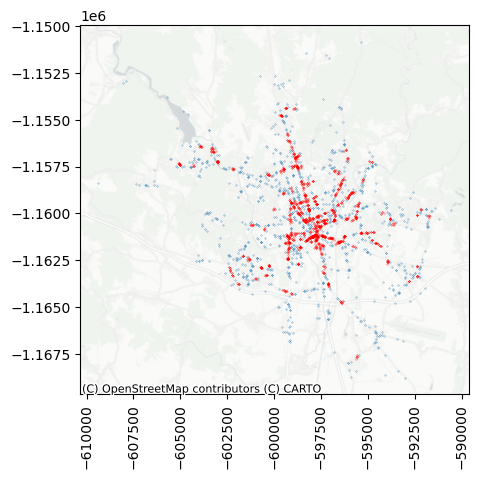

In [39]:
ax = noise.plot(markersize=.05)
clusters.plot(ax=ax, markersize=.05, color='red')
contextily.add_basemap(
    ax=ax,
    crs=accidents.crs,
    source="CartoDB Positron No Labels",
)
plt.xticks(rotation=90);

By default, `DBSCAN` uses 5 as the minimal number of points in a
neighbourhood. If you adjust that, some of the smaller clusters
disappear.

In [40]:
dbscan_100_20 = cluster.DBSCAN(eps=100, min_samples=20)
dbscan_100_20.fit(accidents[["x", "y"]])

DBSCAN(eps=100, min_samples=20)

Assigning the cluster label as a column allows a comfortable plotting of
cluster membership.

In [41]:
accidents['cluster'] = dbscan_100_20.labels_

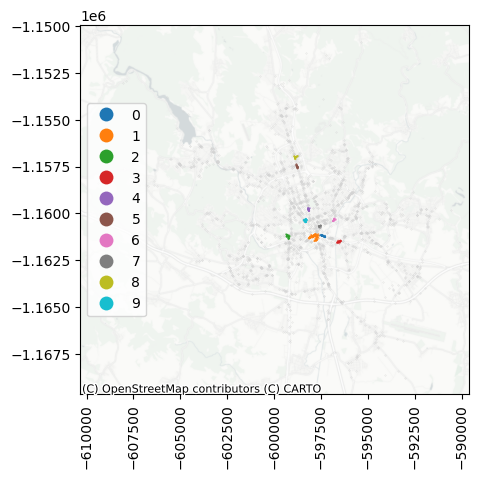

In [42]:
ax = accidents[accidents["cluster"] == -1].plot(
    markersize=0.05, color="lightgrey"
)
accidents[accidents["cluster"] != -1].plot(
    "cluster", categorical=True, ax=ax, markersize=0.1, legend=True
)
contextily.add_basemap(
    ax=ax,
    crs=accidents.crs,
    source="CartoDB Positron No Labels",
)
plt.xticks(rotation=90);

Try for yourself, how the cluster detection changes with a larger or a
smaller epsilon or a different minimum number of samples within a
cluster.

> **Advanced topic**
>
> The part below is optional and may not be covered in the class. It
> contains a slightly more advanced topic of space-time interaction,
> which is another type of analysis you may want to do with a point
> pattern that has a time dimension. Feel free to skip it if you don’t
> feel it is for you.

## Space-time interactions

You have now tested that the point pattern is clustered in space, i.e.,
that there is a spatial interaction between the points. If you have your
points allocated in space **and** time, you can extend this by testing
spatio-temporal interaction.

You will need to derive *time coordinates* from the three columns
containing the date of the incident.

In [43]:
timestamp = pd.to_datetime(
    accidents[["rok", "mesic", "den"]].rename(
        columns={"rok": "year", "mesic": "month", "den": "day"}
    )
)
accidents["days_since_first"] = (timestamp - timestamp.min()).dt.days
accidents["days_since_first"].head()

0     93
1    156
2    156
3    489
4    609
Name: days_since_first, dtype: int64

With the time coordinates ready, you can use the Knox test for
spatiotemporal interaction.

In [44]:
knox = pointpats.Knox.from_dataframe(
    accidents, time_col="days_since_first", delta=500, tau=100
)

The test takes spatial coordinates, time coordinates and two parameters.
`delta` is a threshold for proximity in space (use 500m), while `tau` is
a threshold for proximity in time (use 100 days). Knox test then counts
a number of events that are closer than `delta` in space and `tau` in
time. This count is available as `.statistic_`.

In [ ]:
knox.statistic_

Finally, look at the pseudo-significance of this value, calculated by
permuting the timestamps and re-running the statistics. In this case,
the results indicate there is likely some space-time interaction between
the events.

In [ ]:
knox.p_sim

However, be careful. Combining multiple tests (like you did with
Ripley’s alphabet and Quadrat statistic) before making any conclusions
is always recommended.

> **Additional reading**
>
> Have a look at the chapter [*Point Pattern
> Analysis*](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html#)
> from the Geographic Data Science with Python by @rey2023geographic for
> more details and some other extensions.

## Acknowledgements

This section loosely follows the *Point Pattern Analysis* chapter from
the *Geographic Data Science with Python* by @rey2023geographic.